In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math

In [2]:
from utils_custom import *

In [3]:
# Define file paths
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

# Long trajectory (Day1 to terminal state)

## TF classification by activity (expression + degree dynamics)

In [38]:
lcurve_tf, dtime = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=20, dist=0.001, mode="TF_expression")
#remove rows which have genes/TFs starting with 'ZNF' and 'ZBTB'
lcurve_tf = lcurve_tf[~lcurve_tf.index.str.startswith('ZNF') & ~lcurve_tf.index.str.startswith('ZBTB')]

In [39]:
display(lcurve_tf.head())
display(lcurve_tf.shape)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AHR,6.943979,6.963448,6.976820,6.981472,6.975079,6.955402,6.920087,6.866625,6.792649,6.696762,6.579835,6.446204,6.303712,6.161973,6.029567,5.911886,5.810703,5.725121,5.652911,5.591544
ARID3A,6.489449,6.526009,6.557093,6.584030,6.609424,6.637040,6.671610,6.718398,6.782373,6.866796,6.971420,7.091134,7.216346,7.335675,7.439676,7.523344,7.586238,7.630942,7.661256,7.680930
ARID3B,6.134285,6.189325,6.242699,6.293990,6.343866,6.394011,6.446964,6.505790,6.573443,6.651777,6.740315,6.835403,6.930579,7.018460,7.093222,7.152158,7.195600,7.225796,7.245668,7.257983
ARID5A,6.254277,6.302361,6.342153,6.371326,6.387733,6.389108,6.372822,6.335834,6.275063,6.188401,6.076318,5.943393,5.798509,5.652899,5.516817,5.396882,5.295436,5.211596,5.142818,5.086137
ARID5B,9.107810,9.192558,9.271708,9.342875,9.403602,9.451193,9.482601,9.494477,9.483588,9.447781,9.387422,9.306717,9.213770,9.118704,9.030636,8.955334,8.894727,8.847911,8.812580,8.786124


(328, 20)

#### Get curve chars

In [40]:
dchar_tf = compute_curve_characteristics(lcurve_tf, dtime)
display(dchar_tf.head())
display(dchar_tf.shape)

,Terminal logFC,Transient logFC,Switching time
AHR,-1.352435,0.006965,0.647812
ARID3A,1.191481,0.000000,0.549678
ARID3B,1.123698,0.000000,0.474302
ARID5A,-1.168139,0.039062,0.688945
ARID5B,-0.321686,0.168182,0.810422


(328, 3)

In [41]:
dclass_tf = classify_tf_activity(dchar_tf, 'Terminal logFC', 'Transient logFC')
display(dclass_tf.head())
display(dclass_tf.shape)

,Terminal logFC,Transient logFC,Switching time,tf_class,terminal_z,transient_z,terminal_rank,transient_rank
AHR,-1.352435,0.006965,0.647812,Reductive,-1.007615,-0.298368,73,164
ARID3A,1.191481,0.000000,0.549678,Cumulative,1.396726,-0.390404,47,121
ARID3B,1.123698,0.000000,0.474302,Cumulative,1.332662,-0.390404,52,121
ARID5A,-1.168139,0.039062,0.688945,Reductive,-0.833431,0.125794,94,200
ARID5B,-0.321686,0.168182,0.810422,Bell wave,-0.033419,1.832072,312,29


(328, 8)

In [9]:
top_k_df = get_top_k_tfs_by_class(dclass_tf, k=15)
display(top_k_df)

,Reductive,Cumulative,Bell wave,U-shaped
0,THRB,PRDM1,NFATC4,TFAP4
1,HNF1B,BHLHE41,FOS,E2F6
2,REL,XBP1,EGR1,E2F4
3,BACH2,SOX2,PPARA,YBX1
4,TCF7L2,RUNX2,IKZF2,CENPB
5,IRF8,TP73,NFIA,MLX
6,ZEB2,VDR,MYPOP,MTF1
7,EGR3,MBNL2,MEF2B,CDC5L
8,NR4A3,E2F2,NFATC3,TFDP1
9,TFEC,CREB3L2,RORA,SRF


### Classifying episodic and static enriched TFs

In [42]:
static_enriched_tfs = { 'PB': ['PRDM1','IRF4','CREB3L2','RUNX2','XBP1','AFF1','HERPUD1','HIVEP2','ARID5B','TCF12','TFEC'],
                        'GC': ['PAX5','PBX3','BATF','BACH2']
}

episodically_enriched_tfs = { 'PB': ['TFEC','CREB3L2','MAX','IRF1','IRF8','IRF9','IRF2','TEAD2','MEF2A','IRF7'],
                        'GC': ['POU2F1','CDC5L','IKZF3','USF2','MEF2C']
}

In [43]:
# Select TFs that are in the static PB list
static_enriched_tfs_df = dclass_tf[dclass_tf.index.isin(static_enriched_tfs['PB'])]
display(static_enriched_tfs_df)
static_tfs_by_class = get_top_k_tfs_by_class(static_enriched_tfs_df, k=15)
display(static_tfs_by_class)

,Terminal logFC,Transient logFC,Switching time,tf_class,terminal_z,transient_z,terminal_rank,transient_rank
ARID5B,-0.321686,0.168182,0.810422,Bell wave,-0.033419,1.832072,312,29
CREB3L2,2.179890,0.000000,0.511198,Cumulative,2.330905,-0.390404,16,121
IRF4,1.781675,0.000000,0.557545,Cumulative,1.954538,-0.390404,27,121
PRDM1,4.625343,0.000000,0.535603,Cumulative,4.642185,-0.390404,1,121
RUNX2,2.664457,0.000000,0.533401,Cumulative,2.788886,-0.390404,9,121
TCF12,0.261367,0.000000,0.392525,Cumulative,0.517644,-0.390404,132,121
TFEC,-2.464787,0.051265,0.709693,Reductive,-2.058937,0.287041,22,168
XBP1,3.045474,0.000000,0.566726,Cumulative,3.148998,-0.390404,4,121


/ocean/projects/cis240075p/asachan/bio_informatics_analysis/B_Cells_human_analysis/src/multiome_dynamic_regulation/py_scripts/analysis/utils_custom.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relevant_rank'] = df.apply(get_relevant_rank, axis=1)


,Bell wave,Cumulative,Reductive
0,ARID5B,PRDM1,TFEC
1,None,XBP1,None
2,None,RUNX2,None
3,None,CREB3L2,None
4,None,IRF4,None
5,None,TCF12,None


In [44]:
dynamic_enriched_tfs_df = dclass_tf[dclass_tf.index.isin(episodically_enriched_tfs['PB'])]
display(dynamic_enriched_tfs_df)
dynamic_tfs_by_class = get_top_k_tfs_by_class(dynamic_enriched_tfs_df, k=15)
display(dynamic_tfs_by_class)

,Terminal logFC,Transient logFC,Switching time,tf_class,terminal_z,transient_z,terminal_rank,transient_rank
CREB3L2,2.179890,0.000000,0.511198,Cumulative,2.330905,-0.390404,16,121
IRF1,-0.283544,0.109003,0.770348,Bell wave,0.002630,1.050041,327,59
IRF2,0.438338,0.000000,0.263928,Cumulative,0.684905,-0.390404,110,121
IRF7,0.289368,0.000000,0.506554,Cumulative,0.544109,-0.390404,130,121
IRF8,-2.934518,0.001716,0.609737,Reductive,-2.502896,-0.367734,15,143
IRF9,-0.382290,0.019067,0.636151,U-shaped,-0.090698,-0.138436,280,198
MAX,-0.261945,0.034317,0.762182,Bell wave,0.023044,0.063084,317,215
MEF2A,0.066764,0.171346,0.036188,Bell wave,0.333717,1.873875,185,28
TEAD2,-0.940519,0.018496,0.716982,Reductive,-0.618300,-0.145979,116,196
TFEC,-2.464787,0.051265,0.709693,Reductive,-2.058937,0.287041,22,168


/ocean/projects/cis240075p/asachan/bio_informatics_analysis/B_Cells_human_analysis/src/multiome_dynamic_regulation/py_scripts/analysis/utils_custom.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relevant_rank'] = df.apply(get_relevant_rank, axis=1)


,Cumulative,Bell wave,Reductive,U-shaped
0,CREB3L2,MEF2A,IRF8,IRF9
1,IRF2,IRF1,TFEC,None
2,IRF7,MAX,TEAD2,None


#### Plotting line plots

In [16]:
def plot_tf_activity_by_class(top_k_df, lcurve_tf, dtime, colors=None, figsize=(20, 12), 
                             tfs_per_group=5, groups_per_class=3):
    """
    Plot TF activity curves organized by class and groups.
    
    Parameters:
    -----------
    top_k_df : pandas.DataFrame
        DataFrame where columns are class names and values are TF names
    lcurve_tf : pandas.DataFrame
        DataFrame with TF activity curves (TFs as rows, timepoints as columns)
    dtime : pandas.Series or array-like
        Time points for x-axis
    colors : list, optional
        List of colors for plotting. If None, uses default red shades
    figsize : tuple, optional
        Figure size (width, height)
    tfs_per_group : int, optional
        Number of TFs per group/subplot
    groups_per_class : int, optional
        Number of groups per class
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Default colors (shades of red)
    if colors is None:
        colors = ['#67000d', '#a50f15', '#cb181d', '#ef3b2c', '#fb6a4a']
    
    # Get all classes from top_k_df
    classes = top_k_df.columns.tolist()
    
    # Calculate global y-axis limits
    all_tfs_to_plot = []
    for class_name in classes:
        tf_list = top_k_df[class_name].tolist()
        for tf in tf_list:
            if tf in lcurve_tf.index:
                all_tfs_to_plot.append(tf)
    
    # Get min and max values across all TFs
    y_min = lcurve_tf.loc[all_tfs_to_plot].min().min()
    y_max = lcurve_tf.loc[all_tfs_to_plot].max().max()
    
    # Add padding to the limits
    y_padding = (y_max - y_min) * 0.05
    y_min -= y_padding
    y_max += y_padding
    
    # Create subplot figure
    fig, axes = plt.subplots(groups_per_class, len(classes), figsize=figsize)
    
    # Ensure axes is 2D array even for single row/column
    if groups_per_class == 1:
        axes = axes.reshape(1, -1)
    if len(classes) == 1:
        axes = axes.reshape(-1, 1)
    
    for col_idx, class_name in enumerate(classes):
        tf_list = top_k_df[class_name].tolist()
        
        # Split TFs into groups
        for row_idx in range(groups_per_class):
            start_idx = row_idx * tfs_per_group
            end_idx = start_idx + tfs_per_group
            current_tfs = tf_list[start_idx:end_idx]
            
            ax = axes[row_idx, col_idx]
            
            # Remove top and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Store data for label positioning
            final_y_values = []
            tf_names = []
            colors_used = []
            
            # Plot each TF in the current group
            for i, tf in enumerate(current_tfs):
                if tf in lcurve_tf.index:
                    ax.plot(dtime, lcurve_tf.loc[tf], linewidth=2, 
                           color=colors[i % len(colors)], label=tf)
                    final_y_values.append(lcurve_tf.loc[tf].iloc[-1])
                    tf_names.append(tf)
                    colors_used.append(colors[i % len(colors)])
            
            # Position labels with better spacing
            if final_y_values:
                y_range = y_max - y_min
                min_spacing = y_range * 0.15
                
                # Sort by final y values
                label_data = list(zip(final_y_values, tf_names, colors_used))
                label_data.sort(key=lambda x: x[0])
                
                # Calculate optimal label positions
                label_positions = []
                for i, (original_y, tf_name, color) in enumerate(label_data):
                    if i == 0:
                        label_y = max(y_min + y_range * 0.05, original_y)
                    else:
                        prev_y = label_positions[-1]
                        label_y = max(original_y, prev_y + min_spacing)
                    
                    label_y = min(label_y, y_max - y_range * 0.05)
                    label_positions.append(label_y)
                
                # Redistribute if labels exceed bounds
                if label_positions[-1] > y_max - y_range * 0.05:
                    available_space = y_max - y_min - 2 * (y_range * 0.05)
                    if len(label_positions) > 1:
                        spacing = available_space / (len(label_positions) - 1)
                        for i in range(len(label_positions)):
                            label_positions[i] = y_min + y_range * 0.05 + i * spacing
                    else:
                        label_positions[0] = y_min + available_space / 2
                
                # Place the labels
                for (original_y, tf_name, color), label_y in zip(label_data, label_positions):
                    ax.text(dtime.iloc[-1] + (dtime.iloc[-1] - dtime.iloc[-2]) * 0.2, 
                           label_y, 
                           f'{tf_name}', 
                           color=color, 
                           verticalalignment='center',
                           fontsize=8,
                           fontweight='bold')
            
            # Set fixed y-axis limits
            ax.set_ylim(y_min, y_max)
            
            # Set labels
            if row_idx == groups_per_class - 1:  # Bottom row
                ax.set_xlabel('Pseudotime')
            if col_idx == 0:  # Left column
                ax.set_ylabel('TF activity')
            
            # Set title for top row
            if row_idx == 0:
                ax.set_title(f'{class_name}', fontweight='bold')
            
            # Add group label on the right side
            if col_idx == len(classes) - 1:
                ax.text(1.25, 0.5, f'Group {row_idx + 1}', 
                       transform=ax.transAxes, 
                       rotation=90, 
                       verticalalignment='center',
                       fontweight='bold')
    
    plt.tight_layout()
    return fig, axes

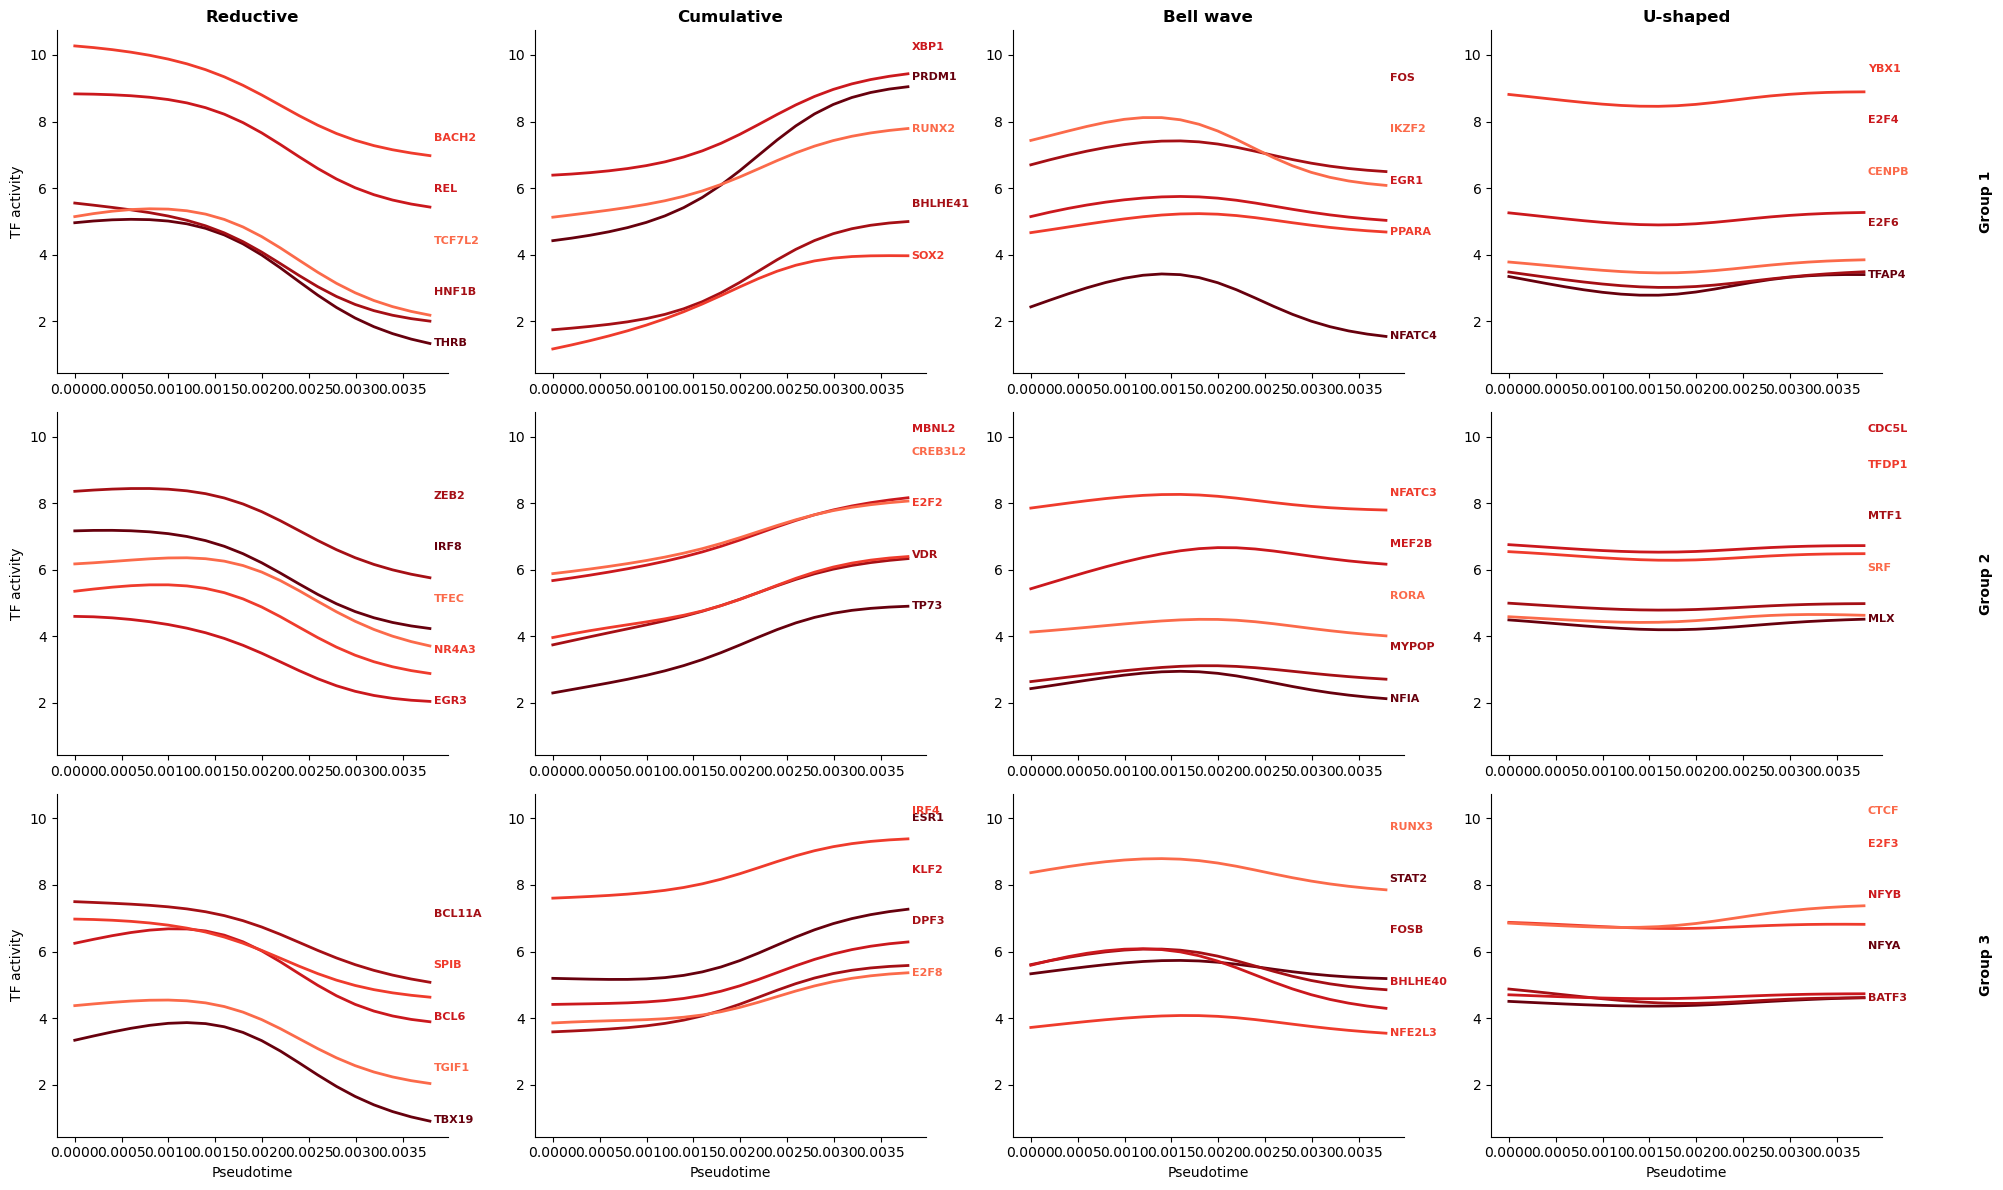

In [24]:
fig, axes = plot_tf_activity_by_class(top_k_df, lcurve_tf, dtime)
plt.show()